# <center>German apartment listings</center>

## 0) Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from timeit import default_timer as timer

import glob
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

import dataprocessing as dproc

%load_ext nb_black
%matplotlib inline

plt.rcParams["figure.dpi"] = 130
pd.set_option("display.precision", 2)
pd.set_option("display.max_columns", None)

<IPython.core.display.Javascript object>

## 1) Data Processing

#### find dates:

In [2]:
dates = sorted(
    [
        s[s.find("mieten") + len("mieten") : s.rfind(".csv")]
        for s in glob.glob("../data/mieten*")
    ]
)

<IPython.core.display.Javascript object>

#### load data:

In [3]:
rent_df = dproc.create_rent_df(dates[-1])
sale_df = dproc.create_sale_df(dates[-1])

<IPython.core.display.Javascript object>

#### add links:

In [4]:
rent_df["link"] = "https://www.immobilienscout24.de/expose/" + rent_df[
    "scoutId"
].astype(str)
sale_df["link"] = "https://www.immobilienscout24.de/expose/" + sale_df[
    "scoutId"
].astype(str)

<IPython.core.display.Javascript object>

#### select features:

In [5]:
rent_select_columns = [
    "rent_m2",
    "baseRent",
    "livingSpace",
    "noRooms",
    "zipCode",
    "regio2",
    "link",
]
rent_select_df = rent_df[rent_select_columns].copy()

sale_select_columns = [
    "price_m2",
    "purchasePrice",
    "livingSpace",
    "noRooms",
    "zipCode",
    "regio2",
    "link",
]
sale_select_df = sale_df[sale_select_columns].copy()

<IPython.core.display.Javascript object>

#### add return of investment based on median rents for zipCode

In [6]:
g = rent_select_df.groupby("zipCode")["rent_m2"].median()
g.name = "rent_m2_zC"
rent_m2_zipCode = sale_select_df.join(g, on="zipCode").copy()["rent_m2_zC"]
sale_select_df.insert(
    loc=sale_select_df.columns.get_loc("zipCode") + 1,
    column="rent_m2_zC",
    value=rent_m2_zipCode,
)

yearly_ROI = sale_select_df["rent_m2_zC"] * 12 / sale_select_df["price_m2"]
sale_select_df.insert(loc=0, column="yearly_ROI", value=yearly_ROI)

<IPython.core.display.Javascript object>

#### remove nans, infs and zeros:

In [7]:
allowed_nan_percentage_cols = 1

rent_select_df = dproc.remove_nan_inf(rent_select_df, allowed_nan_percentage_cols)
sale_select_df = dproc.remove_nan_inf(sale_select_df, allowed_nan_percentage_cols)

rent_select_df = rent_select_df[(rent_select_df["baseRent"] != 0)]
sale_select_df = sale_select_df[(sale_select_df["purchasePrice"] != 0)]

<IPython.core.display.Javascript object>

#### add combined dataframe with median rents and prices:

In [8]:
group = "zipCode"

combined_df = pd.concat(
    [
        rent_select_df.groupby(group)["rent_m2"].median(),
        rent_select_df.groupby(group)["rent_m2"].size(),
        sale_select_df.groupby(group)["price_m2"].median(),
        sale_select_df.groupby(group)["price_m2"].size(),
        sale_select_df.groupby(group)["yearly_ROI"].median(),
    ],
    axis=1,
    keys=[
        "median_rent_m2",
        "num_rent",
        "median_price_m2",
        "num_sale",
        "median_yearly_ROI",
    ],
).copy()

combined_df = combined_df.replace([np.inf, -np.inf], np.nan)
combined_df = combined_df.dropna()

<IPython.core.display.Javascript object>

## 2) Outlier detection apartments for sale

### 2.1) Normalize the data

#### Distribution of living space and prices:

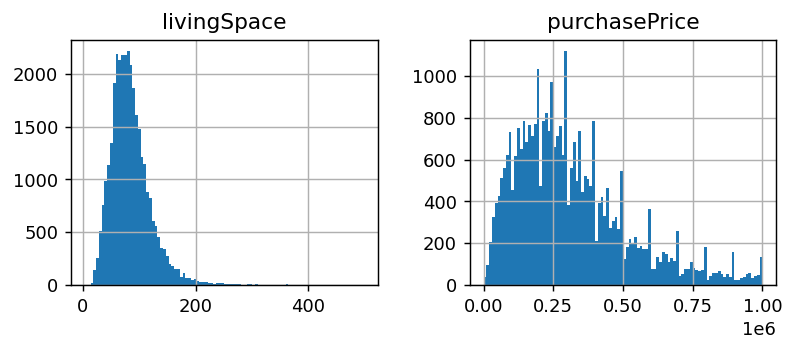

<IPython.core.display.Javascript object>

In [9]:
sale_select_df[["livingSpace", "purchasePrice"]][
    (sale_select_df["purchasePrice"] < 1e6) & (sale_select_df["livingSpace"] < 500)
].hist(bins=100, figsize=(7, 2.5))
pass

#### Boxcox transformation:

Boxcox parameters
livingSpace: lambda = -0.13
purchasePrice: lambda = 0.08


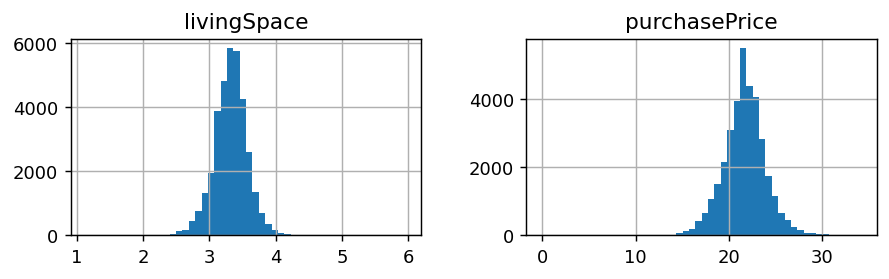

<IPython.core.display.Javascript object>

In [10]:
x_space, lambda_space = stats.boxcox(sale_select_df["livingSpace"])
x_price, lambda_price = stats.boxcox(sale_select_df["purchasePrice"])
X_sale = pd.DataFrame({"livingSpace": x_space, "purchasePrice": x_price})
X_sale.hist(bins=50, figsize=(8, 2))
print(
    f"Boxcox parameters\nlivingSpace: lambda = {lambda_space:.2f}\npurchasePrice: lambda = {lambda_price:.2f}"
)

#### Assumed ratio of outliers:

In [11]:
contamination = 0.002

<IPython.core.display.Javascript object>

### 2.2) Gaussian Elliptic Envelope

In [12]:
start = timer()

sale_outlier = EllipticEnvelope(
    contamination=contamination, random_state=42
).fit_predict(X_sale)
sale_inlier_df = sale_select_df[(sale_outlier == 1)]
sale_outlier_df = sale_select_df[(sale_outlier == -1)]

end = timer()
print(f"Elapsed time: {np.round(end - start,2)}s")

Elapsed time: 10.63s


<IPython.core.display.Javascript object>

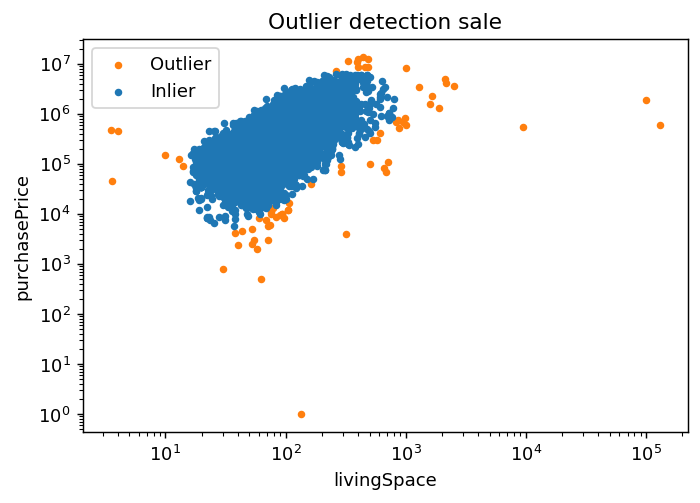

<IPython.core.display.Javascript object>

In [13]:
fig, ax = plt.subplots()
sale_outlier_df.plot.scatter(
    x="livingSpace",
    y="purchasePrice",
    loglog=True,
    title="Outlier detection sale",
    color="C1",
    label="Outlier",
    s=10,
    ax=ax,
)
sale_inlier_df.plot.scatter(
    x="livingSpace", y="purchasePrice", color="C0", label="Inlier", s=10, ax=ax
)
fig.savefig("sale_outlier.png")

## 3) Results

### 3.1) Best ROI nationally

#### Outlier:

In [14]:
df_show = sale_outlier_df.sort_values("yearly_ROI", ascending=False).head(10)
df_show.style.format({"link": dproc.make_clickable})

,yearly_ROI,price_m2,purchasePrice,livingSpace,noRooms,zipCode,rent_m2_zC,regio2,link
30455,13721.54,0.01,1.00,133.00,3.00,27793,8.60,Oldenburg_Kreis,https://www.immobilienscout24.de/expose/116978696
3899,20.40,4.57,599000.00,131000.00,3.00,19055,7.77,Schwerin,https://www.immobilienscout24.de/expose/115364610
31265,10.44,7.98,500.00,62.66,3.00,31698,6.94,Schaumburg_Kreis,https://www.immobilienscout24.de/expose/116556571
32748,4.77,12.58,4000.00,318.00,10.00,4639,5.00,Altenburger_Land_Kreis,https://www.immobilienscout24.de/expose/115369915
35693,3.89,26.67,800.00,30.00,1.00,49152,8.64,Osnabrück_Kreis,https://www.immobilienscout24.de/expose/105011041
35737,3.21,18.68,1850000.00,99015.00,1.00,6385,5.00,Anhalt_Bitterfeld_Kreis,https://www.immobilienscout24.de/expose/104440723
6313,2.91,42.40,3000.00,70.76,3.00,17489,10.27,Greifswald,https://www.immobilienscout24.de/expose/120418469
26130,2.58,57.03,534801.00,9377.00,4.00,90766,12.27,Fürth,https://www.immobilienscout24.de/expose/119423700
31552,1.35,34.48,2000.00,58.00,3.00,6647,3.87,Burgenlandkreis,https://www.immobilienscout24.de/expose/116330431
34722,1.15,54.55,3000.00,55.00,2.00,1589,5.24,Meißen_Kreis,https://www.immobilienscout24.de/expose/112390320


<IPython.core.display.Javascript object>

#### Inlier:

In [15]:
df_show = sale_inlier_df.sort_values("yearly_ROI", ascending=False).head(10)
df_show.style.format({"link": dproc.make_clickable})

,yearly_ROI,price_m2,purchasePrice,livingSpace,noRooms,zipCode,rent_m2_zC,regio2,link
6314,0.52,154.05,5700.00,37.00,1.00,42107,6.67,Wuppertal,https://www.immobilienscout24.de/expose/120418484
6335,0.46,247.34,13000.00,52.56,3.00,25813,9.42,Nordfriesland_Kreis,https://www.immobilienscout24.de/expose/120418377
15975,0.43,198.02,20000.00,101.00,4.00,34127,7.16,Kassel,https://www.immobilienscout24.de/expose/119360686
6324,0.43,262.32,14000.00,53.37,3.00,25813,9.42,Nordfriesland_Kreis,https://www.immobilienscout24.de/expose/120418378
6330,0.43,264.75,14000.00,52.88,3.00,25813,9.42,Nordfriesland_Kreis,https://www.immobilienscout24.de/expose/120418379
6333,0.39,195.59,13300.00,68.00,2.00,47198,6.29,Duisburg,https://www.immobilienscout24.de/expose/120418131
8862,0.37,208.33,10000.00,48.00,3.00,94253,6.50,Regen_Kreis,https://www.immobilienscout24.de/expose/85896472
14765,0.37,210.53,8000.00,38.00,2.00,94253,6.50,Regen_Kreis,https://www.immobilienscout24.de/expose/113269455
18087,0.36,235.00,23500.00,100.00,3.00,67466,7.13,Bad_Dürkheim_Kreis,https://www.immobilienscout24.de/expose/112930756
5511,0.36,162.05,10000.00,61.71,3.00,8412,4.86,Zwickau_Kreis,https://www.immobilienscout24.de/expose/117081262


<IPython.core.display.Javascript object>

### 3.2) Apartments by region

#### regions overview:

In [16]:
min_num = 5
combined_filt_ord = "median_yearly_ROI"

combined_filt = (combined_df["num_rent"] > min_num) & (
    combined_df["num_sale"] > min_num
)
combined_df[combined_filt].sort_values(combined_filt_ord, ascending=False)

,median_rent_m2,num_rent,median_price_m2,num_sale,median_yearly_ROI
zipCode,,,,,
47169,6.20,57,278.90,18.0,0.28
17139,4.99,20,391.11,6.0,0.15
47229,6.57,28,576.92,9.0,0.14
8412,4.86,253,439.31,21.0,0.13
38700,6.50,17,636.36,17.0,0.12
...,...,...,...,...,...
4328,6.50,41,4881.28,42.0,0.02
80333,26.67,39,20115.54,18.0,0.02
83700,16.74,9,12692.31,21.0,0.02


<IPython.core.display.Javascript object>

#### pick regions to further inspect:

In [17]:
regiontype = "zipCode"
regions = [72074]
combined_df.loc[regions]

,median_rent_m2,num_rent,median_price_m2,num_sale,median_yearly_ROI
zipCode,,,,,
72074,12.5,15,4954.84,3.0,0.03


<IPython.core.display.Javascript object>

### 3.3) Apartments for rent

In [18]:
rent_filt = rent_select_df[regiontype].isin(regions)
df_show = rent_select_df[rent_filt].sort_values("rent_m2")

df_show.style.format({"link": dproc.make_clickable})

,rent_m2,baseRent,livingSpace,noRooms,zipCode,regio2,link
67970,10.00,1500.00,150.00,5.00,72074,Tübingen_Kreis,https://www.immobilienscout24.de/expose/118496278
41309,10.06,1150.00,114.35,4.50,72074,Tübingen_Kreis,https://www.immobilienscout24.de/expose/120380471
43909,10.26,595.00,58.00,2.00,72074,Tübingen_Kreis,https://www.immobilienscout24.de/expose/120314110
50368,11.00,924.00,84.00,3.00,72074,Tübingen_Kreis,https://www.immobilienscout24.de/expose/120135517
2494,11.67,700.00,60.00,2.50,72074,Tübingen_Kreis,https://www.immobilienscout24.de/expose/120267922
43074,12.00,1020.00,84.98,3.00,72074,Tübingen_Kreis,https://www.immobilienscout24.de/expose/120335282
47350,12.22,1150.00,94.10,3.50,72074,Tübingen_Kreis,https://www.immobilienscout24.de/expose/120230564
40707,12.50,450.00,36.00,1.00,72074,Tübingen_Kreis,https://www.immobilienscout24.de/expose/120408819
94892,13.23,410.00,31.00,1.00,72074,Tübingen_Kreis,https://www.immobilienscout24.de/expose/96006808
14255,14.00,1470.00,105.00,3.00,72074,Tübingen_Kreis,https://www.immobilienscout24.de/expose/117551317


<IPython.core.display.Javascript object>

### 3.4) Apartments for sale

In [19]:
sale_filt = sale_select_df[regiontype].isin(regions)
df_show = sale_select_df[sale_filt].sort_values("yearly_ROI", ascending=False)

df_show.style.format({"link": dproc.make_clickable})

,yearly_ROI,price_m2,purchasePrice,livingSpace,noRooms,zipCode,rent_m2_zC,regio2,link
11463,0.03,4736.84,360000.00,76.00,3.00,72074,12.50,Tübingen_Kreis,https://www.immobilienscout24.de/expose/116571440
3389,0.03,4954.84,768000.00,155.00,4.00,72074,12.50,Tübingen_Kreis,https://www.immobilienscout24.de/expose/117501062
20160,0.03,5572.73,613000.00,110.00,4.50,72074,12.50,Tübingen_Kreis,https://www.immobilienscout24.de/expose/117071241


<IPython.core.display.Javascript object>